# Table of Contents
* [HTC Vive Signal Processing](#HTC-Vive-Signal-Processing)
	* [Implementation, Hardware](#Implementation,-Hardware)
	* [Implementation, Software](#Implementation,-Software)
		* [1. Pulse detection](#1.-Pulse-detection)
		* [2. Package detection](#2.-Package-detection)
		* [3. Signal extraction](#3.-Signal-extraction)
	* [Verification](#Verification)
		* [High Pass Filter](#High-Pass-Filter)
		* [Processor Hardware Filtration](#Processor-Hardware-Filtration)
		* [Pulse detection](#Pulse-detection)
		* [Package detection](#Package-detection)
		* [Extracting signal](#Extracting-signal)
			* [Determining package type](#Determining-package-type)
			* [Determining signal value](#Determining-signal-value)
	* [Sources](#Sources)


In [1]:
% matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft

# HTC Vive Signal Processing

The HTC Vive Base Station units operate in pairs to send pulses that can be used to determine an objects position relative to the units. All processing occurs on the object, resulting in a system where the only mode of entry to determining the position of the object is the object itself. 

Each base station unit consists of a line laser that rotates at 120 rpm in both the horizontal and vertical plane. By determining the time taken from the first calibration-pulse arrives to when the laser-pulse arrives, the relative angle between the object and the base station unit can be determined. Calibration-signals are used by both base so they can synchronize internally and to let the object know which line-laser signal it is going to read. The pulse-sequences are summarized in this table:

| Pulse start, µs | Pulse length, µs | Source station | Meaning |
| --------: | ---------: | -------------: | :------ |
|         0 |     65–135 |              A | Sync pulse (LED array, omnidirectional) |
|       400 |     65-135 |              B | Sync pulse (LED array, omnidirectional) |
| 1222–6777 |        ~10 |         A or B | Laser plane sweep pulse (center=4000µs) |
|      8333 |            |                | End of cycle |

The duration of the calibration-pulses shows which line laser is about to pass to produce a signal. Axis 0 is horizontal whereas axis 1 is vertical.  

Name | skip | data | axis  | length (ticks) | length (µs)
-----|------|------|-------|----------------|------------
j0   | 0    | 0    | 0     | 3000           | 62.5
k0   | 0    | 0    | 1     | 3500           | 72.9
j1   | 0    | 1    | 0     | 4000           | 83.3
k1   | 0    | 1    | 1     | 4500           | 93.8
j2   | 1    | 0    | 0     | 5000           | 104
k2   | 1    | 0    | 1     | 5500           | 115
j3   | 1    | 1    | 0     | 6000           | 125
k3   | 1    | 1    | 1     | 6500           | 135

## Implementation, Hardware

The following circuit is used to detect the IR signal and process it for the micro-controller. 
<img src="Signal Processing resources/circuit.svg" alt="Sensor Circuit"/>
Source: https://github.com/ashtuchkin/vive-diy-position-sensor

## Implementation, Software

The implemented algorithm uses the Teensy 3.1 processor running at 72 MHz. Flex timers are used to determine pulse lengths and a falling edge interrupt routine collects this information and passes it to the main thread of the algorithm. The digital signal processing is broken into three steps:

### 1. Pulse detection 

Information from the separation of pulses is used to determine whether a pulse is correctly detected or whether the rising edge is caused by noise. There is some over-saturation occurring in the circuit to produce a lagging peak after the calibration pulses have passed.

### 2. Package detection 

The information in table 1 is used to identify the first and second calibration peaks as well as the following line-laser pulse and any associated noise. The fact that packages arrive sequentially enables the system to infer which signal type is going to arrive after an initial calibration period. The calibration pulse durations as well as the signal length is passed on to interpret the signal.

### 3. Signal extraction

We know the calibration pulses are being sent in a given order: 

1. horizontal pulse from master
2. vertical pulse from master
3. horizontal pulse form slave
4. vertical pulse from slave

The algorithm is therefore written to have a calibration-step after initialization where it verifies this ordering or multiple pulse cycles, before it uses the precise timing-information between packages to infer the which signal arrives at what time. This is a very robust system with the following advantages:

- Thousands of consecutive packages can be lost due to mechanical interference without impeding the systems ability to regain the signal.
- After proper calibration, there is no chance for interpreting the signal type incorrectly. 
- The start-time of each pulse us used to ensure small drifts in timing between the base station and the Teensy causes the system to fail after some time.

The functionality is summarized in the following flow-chart. 
<img src="Signal Processing resources/HTC Vive Signal Processing - Page 1.svg" alt="Drawing" style="width: 500px;"/>

The signal output from the system is in degrees, and measured from the center line of the front-face of the each base station unit as shown.

<img src="Signal Processing resources/Base station.svg" alt="Base station angle zero definition" style="width: 250px;"/>

## Verification

### High Pass Filter

The high pass filter is seen to remove the DC component form the signal coming out of the first Op-Amp during normal operation. In the figure below, the sensor is located about 1.8 meters from the base stations. In this senario we seen the calibration pulses do not saturate the first Op-Amp as the signal coming into the capacitor has an amplitude less than ACC (5V). We also observe the large deviation in amplitude between the amplitude of the calibration signals (located at 0.0000 and 0.0005 seconds) as opposed to the line-laser signals (located at -0.0038 and 0.0048 seconds).

<IPython.core.display.Javascript object>


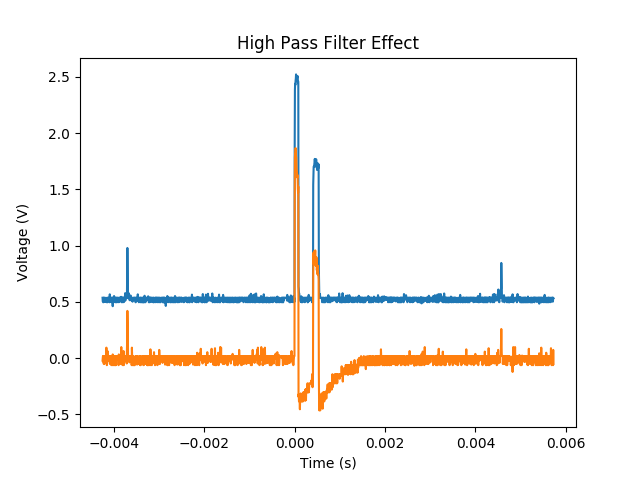

In [2]:
data = np.loadtxt(open("Signal Processing resources/across capacitor.csv", "rb"), delimiter=",", skiprows=1)
plt.figure()
plt.plot(data[:,0], data[:,1])
plt.plot(data[:,0], data[:,2])
plt.xlabel("Time (s)") 
plt.ylabel("Voltage (V)") 
plt.title("High Pass Filter Effect")

### Processor Hardware Filtration

Using the Input Capture Filter Control mechanism on the MK20DX256VLH7 processor, the input signal from the IR sensor circuit is smoothed through a low pass filter and its voltage level decreased to 3.3 V as we can see in the figure below.

<IPython.core.display.Javascript object>


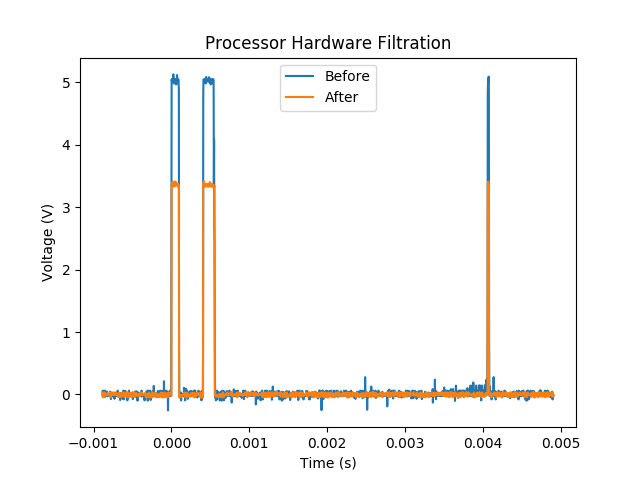

In [3]:
data = np.loadtxt(open("Signal Processing resources/teensy filtration.csv", "rb"), delimiter=",", skiprows=1)
plt.figure()
plt.plot(data[:,0], data[:,1])
plt.plot(data[:,0], data[:,2])
plt.xlabel("Time (s)") 
plt.ylabel("Voltage (V)") 
plt.legend(["Before", "After"])
plt.title("Processor Hardware Filtration")

By zooming in on the end of the second peak, we see how this final layer of hardware filtering squares the trailing edge of the signal without generating small pulses for the input oscillations.

<IPython.core.display.Javascript object>


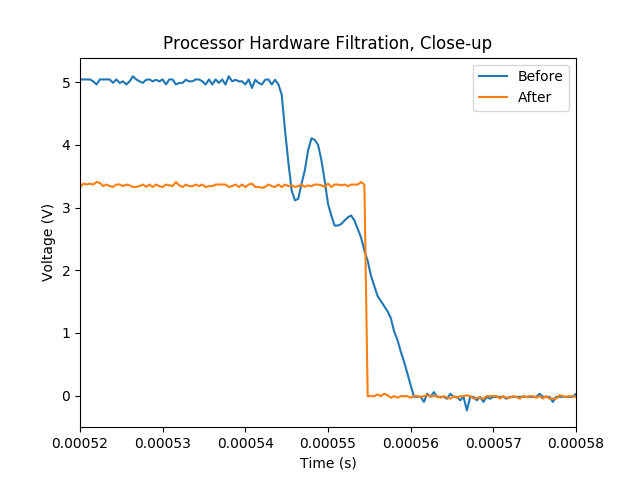

In [4]:
data = np.loadtxt(open("Signal Processing resources/teensy filtration close.csv", "rb"), delimiter=",", skiprows=1)
plt.figure()
plt.plot(data[:,0], data[:,1])
plt.plot(data[:,0], data[:,2])
plt.xlim([0.00052,0.00058])
plt.xlabel("Time (s)") 
plt.ylabel("Voltage (V)") 
plt.legend(["Before", "After"])
plt.title("Processor Hardware Filtration, Close-up")

### Pulse detection

The first layer of digital processing performed is simply to pick out pulses. Tests have revealed that there is a danger of a rebound pulse arising if the Op-Amps become to heavily saturated. This is handled to some extent by discarding pulses that arrive too close to the end of another pulse. 
<img src="Vive Signal Processing Resources/pulse-issue.png" alt="Pulse issue">

### Package detection

The first trials of the system were performed too close to the base station units, saturating the Op-Amps and resulting in significant increase in the duration of the pulses as well as rebound issues. Updates to make the algorithm more robust as well as moving the sensor further away fixed these issues, resulting in a clear a pulse width histogram that consists of eight clearly separated peaks for each base station. It should however be noted that the pulse widths from the master and the slave units are shifted in relation to each other. Further investigation reviled this to be a problem related to the incident angle on the sensor. The need for a dynamic classification algorithm to determine the nature of each signal was thus identified and implemented.

The following calibration pulses were collected at a distance of 1.5 m from the base stations.

<IPython.core.display.Javascript object>


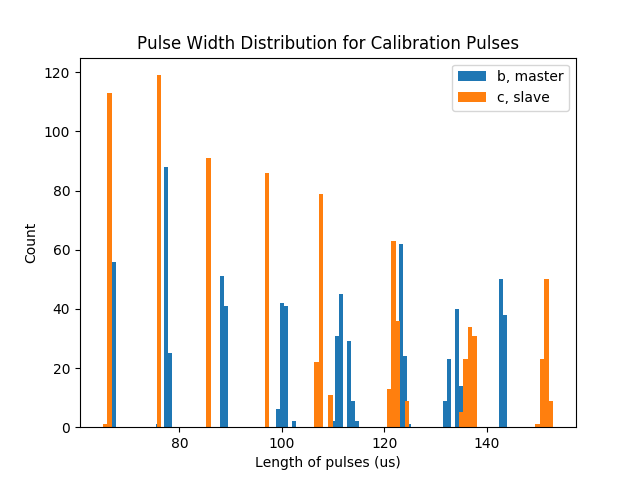

In [5]:
val = np.loadtxt(open("Signal Processing resources/pulseWidths2.txt", "rb"), delimiter=",", skiprows=1)
plt.figure()
plt.hist(val[:,0], bins=100)
plt.hist(val[:,1], bins=100)
plt.xlabel("Length of pulses (us)") 
plt.ylabel("Count") 
plt.legend(["b, master", "c, slave"])
plt.title("Pulse Width Distribution for Calibration Pulses")

An algorithm was designed to look at multiple pulses and search for the pattern expected from a successfully read package. Only if the entire pattern is recognized is the package approved and passed on to extract the signal from it. 

### Extracting signal

From each package we need to extract information regarding which angle the package contains information about (through the duration of the calibration-pulses) and the angle itself.

#### Determining package type

The dynamic classification that we earlier identified would be necessary to interpret which of the eight peaks each base station calibration signal belongs to was here implemented. It was done using an array, storing n (40 seems to work well) last calibration pulse-widths. The peaks are always seen to be evenly distributed, so the max and min value of peak length is extracted and eight classes computed with equal width to cover that range. Master and slave-values are stored and classified separately.

Due to the sequential nature of the packages, it is after an initial calibration period sufficient to determine when the package arrives to identify what angle is being provided. This increases accuracy and efficiency of the algorithm for normal operation, as discussed in the section on software implementation. This is seen to work very well in practice, providing stable readouts for all angles.

#### Determining signal value

We now turn to verifying the angle-measurements and evaluating the overall accuracy of the system. Positioning the base stations at one end of the desk, the sensor is positioned at the other side to achieve an appropriate separation as shown in the image below. Moving the sensor sideways relative to the center-line between the base stations, the angles obtained can be calculated using trigonometry as follows:

$\theta = \arctan\left(\frac{x}{1655}\right)$, 
$\phi_b = \arctan\left(\frac{x+350}{1655}\right)$, 
$\phi_c = \arctan\left(\frac{x-350}{1655}\right)$

<img src="Vive Signal Processing Resources/Setup.svg">

A suitable set of x-values was chosen to take repeat measurements of angles and compare them to actual values. There is a calibration-constant required to make the angles be relative to the center-line between the base station. This calibration constant has been applied to the measured angles below so that the first angle measurements $\theta = 0$ is aligned. 

| x (mm) | $\theta$ (deg) | $\phi_b$ (deg) | Measured $\phi_b$ (deg) | $\Delta\phi_b$ (deg) | $\phi_c$ (deg) | Measured $\phi_c$ (deg) | $\Delta\phi_c$ (deg) |
|--------|----------------|----------------|-------------------------|----------------------|----------------|-------------------------|----------------------|
| 0      | 0              | 11.94          | 11.94                   | 0                    | -11.94         | -11.94                  | 0                    |
| 150    | 5.18           | 16.81          | 16.85                   | -0.04                | -6.89          | -6.65                   | -0.24                |
| 300    | 10.27          | 21.44          | 21.4                    | 0.04                 | -1.73          | -1.75                   | 0.02                 |
| 450    | 15.21          | 25.8           | 25.52                   | 0.28                 | 3.46           | 3.25                    | 0.21                 |
| 600    | 19.93          | 29.86          | 29.6                    | 0.25                 | 8.59           | 8.05                    | 0.54                 |
| 750    | 24.38          | 33.61          | 32.9                    | 0.71                 | 13.59          | 12.65                   | 0.94                 |

As we can see, the angles are measured with fair accuracy in this range. See [Vive Validation](Vive Validation.ipynb) accuracy-evaluation.

## Sources

- https://github.com/ashtuchkin/vive-diy-position-sensor
- https://github.com/nairol/LighthouseRedox/blob/master/docs/Light%20Emissions.md
- http://www.nxp.com/assets/documents/data/en/reference-manuals/K20P64M72SF1RM.pdf